# Exploratory Data Analysis of Weather in Illinois

In [1]:
from pathlib import Path # Library used for handling paths
import pandas as pd # DataFrame library
import numpy as np # Array library
import matplotlib.pyplot as plt # Plotting library
import os # operating system module used for storing credentials into the environment variable

### The data was extracted from the NOAA's Global Historical Climatology Network (GHCN) dataset. The SQL query was run in the Google BigQuery console as shown below. The resulting dataset was saved to a dataframe as shown in the next cell.

![Illinois Temperature Data (1990 - 2023).png](<attachment:Illinois Temperature Data (1990 - 2023).png>)

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./secrets/my_credentials.json" # Credentials to be able to access the Google BigQuery public datasets

### To save on time and prevent potential costly charges, the queried result was downloaded as .csv file. It is possible to insert the queried result directly to a pandas DataFrame as shown in the code block below. Here's an example for querying just the temperature variables.
```python
raw_weather_query = """SELECT weather.id, weather.date, weather.element, weather.value, weather.qflag, 
                       stations.latitude, stations.longitude, stations.state, stations.name 
                       FROM `bigquery-public-data.ghcn_d.ghcnd_*` AS weather
                       INNER JOIN `bigquery-public-data.ghcn_d.ghcnd_stations` AS stations
                       ON weather.id = stations.id
                       WHERE weather.id LIKE 'US%'
                       AND weather.element IN ('TMAX', 'TMIN', 'TAVG', 'TOBS')
                       AND weather.qflag IS NULL
                       AND EXTRACT(YEAR FROM weather.date) BETWEEN 1990 AND 2023
                       AND weather._TABLE_SUFFIX BETWEEN '1990' AND '2023'
                       AND stations.id LIKE 'US%'
                       AND stations.state = 'IL'; """ # This query extracts weather data from the US in Illinois from the year 1990 to 2023
raw_weather_data = pd.read_gbq(raw_weather_query, use_bqstorage_api = True, progress_bar_type = "tqdm_notebook", dialect = "standard") # Load the data from the SQL query through Google BigQuery
```

In [14]:
raw_weather_data = pd.read_csv("illinois_weather_data.csv", sep = ",")
raw_weather_data.drop(["qflag", "state", "id"], axis = 1, inplace = True) # Drop the qflag, state, and id columns
raw_weather_data["date"] = pd.to_datetime(raw_weather_data["date"]) # Convert the date column from a generic object type to a datetime object
raw_weather_data["time"] = pd.to_datetime(raw_weather_data["time"]) # Convert the time column from a generic object type to a datetime object
raw_weather_data.sort_values(by = "date", ignore_index = True, inplace = True) # Sort the temperatures by date
raw_weather_data = raw_weather_data[["date", "time", "name", "element", "value", "latitude", "longitude"]] # Reorder the columns
raw_weather_data

SyntaxError: unterminated string literal (detected at line 5) (3573174016.py, line 5)

In [5]:
raw_weather_data_pivot = raw_weather_data.pivot(columns = "element", values = "value_degF") # Converts the categorical data in the elements column to their own respective columns

In [6]:
transformed_temp_data = pd.concat([raw_weather_data, raw_weather_data_pivot], axis = 1) # combine the newly generated columns with the existing dataframe
transformed_temp_data.drop(["element", "value", "value_degF"], axis = 1, inplace = True) # drop the element and value columns
transformed_temp_data

,date,name,latitude,longitude,TAVG,TMAX,TMIN,TOBS
0,1990-01-01,WATSEKA 2NW,40.7939,-87.7544,NaN,30.92,NaN,NaN
1,1990-01-01,PANA,39.3686,-89.0867,NaN,35.96,NaN,NaN
2,1990-01-01,ALEDO,41.1978,-90.7447,NaN,30.02,NaN,NaN
3,1990-01-01,NEWTON 6 SSE,38.9136,-88.1183,NaN,32.00,NaN,NaN
4,1990-01-01,MARENGO,42.2636,-88.6078,NaN,28.94,NaN,NaN
...,...,...,...,...,...,...,...,...
4826046,2023-11-21,SHELBYVILLE DAM,39.4078,-88.7739,NaN,NaN,41.00,NaN
4826047,2023-11-21,JOLIET BRANDON ROAD LOCK/DAM,41.5033,-88.1033,NaN,NaN,30.02,NaN
4826048,2023-11-21,ANNA 4 N,37.5222,-89.2486,NaN,60.08,NaN,NaN
4826049,2023-11-21,NEW BOSTON DAM 17,41.1925,-91.0578,NaN,50.00,NaN,NaN


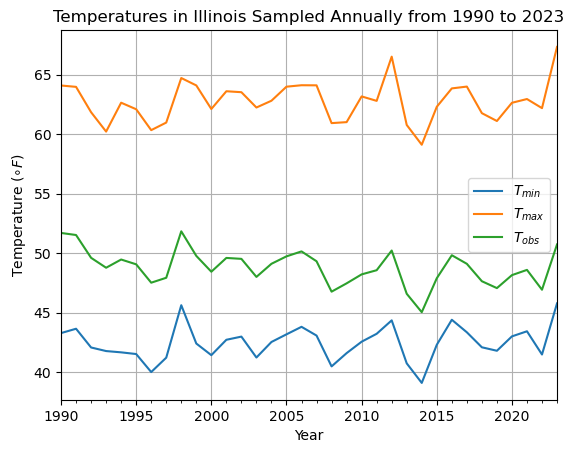

In [7]:
# This code plots the minimum, maximum, average, and observed temperatures
ax = (transformed_temp_data[["date","TMIN", "TMAX", "TOBS"]].resample("Y", on = "date").mean() # Resample the temperature dataframe over one year (originally was sampled per day)
      .plot(xlabel = "Year", ylabel = r"Temperature ($\circ F$)", grid = True, title = "Temperatures in Illinois Sampled Annually from 1990 to 2023"))
ax.legend(loc = "best", labels = [r"$T_{min}$", r"$T_{max}$", r"$T_{obs}$"]) # Format the temperature labels

In [8]:
transformed_temp_data["name"].nunique() # number of stations in Illinois

209

In [9]:
transformed_temp_data["name"].unique() # list of all the station names

array(['WATSEKA 2NW', 'PANA', 'ALEDO', 'NEWTON 6 SSE', 'MARENGO',
       'NASHVILLE 1 E', 'ROSICLARE 5NW', 'OTTAWA 4SW', 'KEWANEE 1 E',
       'GALESBURG', 'NORMAL 4NE', 'EFFINGHAM 3SW', 'TISKILWA 2 SE',
       'PAW PAW 2S', 'DIXON 1W', 'MONMOUTH', 'DANVILLE',
       'CARBONDALE SEWAGE PLT', 'KANKAKEE WWTP', 'WAUKEGAN',
       'CHICAGO BOTANIC GARDEN', 'ROCKFORD GTR ROCKFORD AP',
       'WHITE HALL 1 E', 'SMITHLAND L&D', 'CHENOA', 'MT VERNON 3 NE',
       'DIXON SPRINGS AGRIC CTR', 'GENERAL WAYNE A DOWNING INTL A',
       'MORRISONVILLE', 'PIPER CITY', 'ANTIOCH', 'HILLSBORO',
       'FAIRFIELD RADIO WFIW', 'OLIVE BRANCH', 'BENTON 2 N', 'MT CARROLL',
       'BROOKPORT DAM 52', 'MT CARMEL', 'GLENVIEW NAS', 'MASON CITY 4SE',
       'LACON', 'CHARLESTON', 'PRINCEVILLE', 'GENESEO', 'JACKSONVILLE 2E',
       'MINONK', 'FULTON L&D #13', 'PAXTON 2 WSW',
       'MOLINE QUAD CITY INTL AP', 'LA HARPE', 'CARLINVILLE', 'ELGIN',
       'WATERLOO 6SW', 'DECATUR WTP', 'SPARTA 1 W', 'ALBION',
       'M

In [10]:
num_obs_per_station = transformed_temp_data.filter(regex = "name|T+", axis = 1).groupby("name", as_index = False).count() # number of observations per station
num_obs_per_station

,name,TAVG,TMAX,TMIN,TOBS
0,ALBION,0,5233,5072,5047
1,ALEDO,0,11922,11899,11901
2,ALTON - MELVIN PRICE L&D,0,10636,10298,10659
3,ALTONA,0,6012,5998,5828
4,ANNA 4 N,0,8687,8730,8262
...,...,...,...,...,...
204,WAUKEGAN,0,4340,4058,3986
205,WHEATON 3 SE,0,7686,7736,6652
206,WHITE HALL 1 E,0,12204,12162,12106
207,WINCHESTER,0,5811,5782,5782


In [11]:
num_obs_per_station[num_obs_per_station["name"].str.contains("CHICAGO")] # number of observations per category where the station has the name "CHICAGO"

,name,TAVG,TMAX,TMIN,TOBS
35,CHICAGO AURORA MUNI AP,2455,9107,9104,0
36,CHICAGO BOTANIC GARDEN,0,10675,10606,10560
37,CHICAGO MIDWAY AP,2676,9680,9681,0
38,CHICAGO MIDWAY AP 3SW,0,12373,12372,12368
39,CHICAGO NORTHERLY IS,0,6487,6465,6478
40,CHICAGO OHARE INTL AP,6560,12376,12376,0
41,CHICAGO PALWAUKEE AP,2656,9905,9901,0
42,CHICAGO UNIV,0,1742,1760,1743
43,CHICAGO W CHICAGO DUPAGE AP,2653,9598,9600,0
44,CHICAGO WAUKEGAN RGNL AP,2144,8793,8779,0


In [12]:
num_obs_per_station.min() # Station with the least number of observations

name    ALBION
TAVG         0
TMAX         0
TMIN         0
TOBS         0
dtype: object

In [13]:
num_obs_per_station.max() # Station with the most number of observations

name    WINDSOR
TAVG       7505
TMAX      12376
TMIN      12376
TOBS      12368
dtype: object